# Kaggle Comp: predicting house prices 

We're going to do something noone's ever done before: predict house prices of houses in Boston from 1971. I originally did this on a visual programming platform called [Orange](https://orange.biolab.si/), so I'll follow that workflow pretty closely for simplicity. 

You can find the kaggle competition by clicking [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).



#### Sections:
1. Imports
2. Dimension reduction
3. Model exploring
4. Model tuning
5. Visualising model quality
6. Making and saving predictions

## Imports

In [1]:
%%time

# data manipulation
import pandas as pd
import numpy as np

# visuals
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks")

# dimension reduction
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# splitting data
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import AdaBoostRegressor

# metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# model save
import pickle

Wall time: 2.82 s


#### Data Cleaning functions

## Getting to know the data

Let's have a look at the data and its attributes first.

In [2]:
input_data = pd.read_csv(r".\Data\train.csv").set_index('Id')

In [3]:
input_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print('Shape:',input_data.shape, '\n'*2)
input_data.info()

Shape: (1460, 80) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   

There's a few immediate inferences we can make with this information:
1. There's a lot of columns, and we don't want our model to suffer the curse of dimensionality. We'll have to fix that. 
2. There's null values, and scikit learn doesn't like that. We can remove the columns that contain null values, which also helps with 1.
3. There's non-numeric values, and scikit learn doesn't like that either We'll have to change those to numeric ones.
4. There's still quite a few columns, a problem that can be solved with PCA and Select K Best.
5. Clearly we can pipeline this, seeing as we've put these steps in an order. That'll make things much cleaner.

First, we'll partition our data appropriately.

In [5]:
features = input_data.iloc[:, :-1]
target = input_data.iloc[:, -1]

X_train, X_test, y_train, y_test, = train_test_split(features, target,  test_size = 0.3)


## Pipelines and dimension reduction

We'll need to define some of our cleaning functions, and turn them into classes. Easy with scikit learn.
We'll make two cleaning pipelines, one for train and one for test, since the SelectKBest classes requires target values to work. 

In [21]:
# Removing null values
def no_nulls(df):
    sparse_attrs = df.columns[df.isnull().sum() > 0]
    return df.drop(sparse_attrs, axis=1)

# changing niminal values to numeric ones
def nom2numeric(df):
    cols = df.columns
    for col in cols:
        if df[col].dtype == object:
            df[col] = df[col].astype('category')
            df[col] = df[col].cat.codes
    return df

In [22]:
remove_nulls = FunctionTransformer(no_nulls)
nom_to_numeric = FunctionTransformer(nom2numeric)

In [23]:
preprocessor_train = Pipeline([('Remove_nulls', remove_nulls), 
                     ('Nominal_to_numeric', nom_to_numeric),
                     ('Select_features', SelectKBest(chi2, k=20)),
                     ('pca', PCA(n_components = 10, svd_solver='full')),
                    ])

X_train_pp = preprocessor_train.fit_transform(X_train, y_train)

In [24]:
preprocessor_test = Pipeline([('Remove_nulls', remove_nulls), 
                     ('Nominal_to_numeric', nom_to_numeric),
                     ('pca', PCA(n_components = 10, svd_solver='full')),
                    ])

X_test_pp = preprocessor_test.fit_transform(X_test)

### Model Exploring

In [25]:
def get_models():
    models = {'LinearRegression': LinearRegression(),
              'RidgeCV': RidgeCV(),
              'AdaBoost': AdaBoostRegressor(),
              'AdaBoost with Linear Base': AdaBoostRegressor(base_estimator=LinearRegression()),
              'AdaBoost with Ridge CV Base': AdaBoostRegressor(base_estimator=RidgeCV())
        }
    
    return models

In [26]:
def scores_list_to_df(scores):
    """
    Takes a list and turns it into a sorted dataframe through a dict
    in an intermediate step.
    
    Args:
        scores: List of scores with models attributed to them

    Returns:
        A dataframe sorted by MAE abd RMSE
    
    """
    score_dict= dict((key,d[key]) for d in scores for key in d)
    score_df = pd.DataFrame.from_dict(score_dict, orient='index', columns=['R^2', 'MAE'])
    
    return score_df.sort_values(by=['R^2', 'MAE'])
    

LinearRegression
R^2: -0.18
MAE: 42639.56 

RidgeCV
R^2: -0.18
MAE: 42639.54 

AdaBoost
R^2: 0.47
MAE: 38196.99 

AdaBoost with Linear Base
R^2: -0.49
MAE: 45422.44 

AdaBoost with Ridge CV Base
R^2: -0.35
MAE: 45017.73 



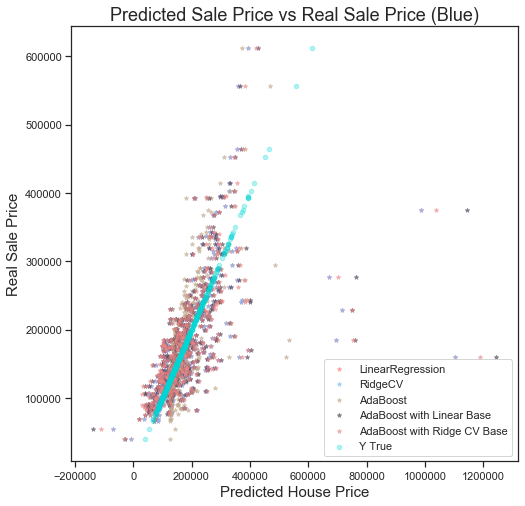

In [27]:
models = get_models()
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

colors = iter(cm.rainbow(np.linspace(0, 1, 10)))

CUSTOM_COLOURS = ['#ff7675', '#74b9ff', '#BFA588',
                  '#4B3A51', '#ea8685', '#E7CA6B',
                 '#C2AF46', '#ff4757', '#00d8d6']
model_scores = [] 
    
for i, model in enumerate(models):
    print(model)
    regr = models[model]
    regr.fit(X_train_pp, y_train)
    preds = regr.predict(X_test_pp)
    
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    
    print('R^2:',r2.round(2))
    print('MAE:',mae.round(2), '\n')
    
    scores = {model:[r2, mae]}
    model_scores.append(scores)
    
    ax1.scatter(preds,y_test, s=17, c=CUSTOM_COLOURS[i],
                marker="*", label=model, alpha=0.5)

    
    
ax1.scatter(y_test, y_test, s = 20, c = CUSTOM_COLOURS[8],
            label = 'Y True', alpha = 0.3, marker = "o")

plt.title('Predicted Sale Price vs Real Sale Price (Blue)', fontsize=18)
plt.xlabel('Predicted House Price', fontsize=15)
plt.ylabel('Real Sale Price', fontsize=15)
plt.legend(loc='lower right')
plt.show()


model_scores_df = scores_list_to_df(model_scores)

In [28]:
model_scores_df

,R^2,MAE
AdaBoost with Linear Base,-0.487657,45422.441499
AdaBoost with Ridge CV Base,-0.352899,45017.725678
LinearRegression,-0.184388,42639.559558
RidgeCV,-0.184385,42639.536449
AdaBoost,0.469379,38196.988695


#### Save and load best Model

In [29]:
label = model_scores_df.index[-1]

best_model = models[label]
filename = 'best_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_pp, y_test)
print(result)

0.469378608045863


## Making and saving predictions

In [30]:
test_data_df = pd.read_csv(r".\Data\test.csv").set_index('Id')
test_features = preprocessor_test.fit_transform(test_data_df)

In [31]:
real_preds = loaded_model.predict(test_features)

In [32]:
real_preds.std()

31975.130369103957

In [33]:
submission_filename = 'submission_file.csv'
submission_df = pd.DataFrame(data = real_preds, index = test_data_df.index, columns=['SalePrice'])
submission_df.head()

,SalePrice
Id,
1461,174369.669797
1462,492220.317204
1463,188143.698262
1464,175404.079687
1465,153555.758530


In [34]:
submission_df.to_csv(submission_filename)